# Rotation algorithm : E[v],E[w]=0

In [1]:
import numpy as np
import pandas as pd

# Funzione per eseguire la rotazione singola/doppia/tripla
def Rotation_1_2_3(datiorari, zero_rot=True, first_rot=True, second_rot=False): #SECOND ROT IS NOW FALSE
    # zero_rot=TRUE    # to perform first rotation (<v>=0)
    # first_rot=TRUE   # to perform second rotation (<w>=0)
    # second_rot=TRUE  # to perform third rotation (<v'w'>=0) #ammazzare il flusso per concentrarsi su un flusso "bidimensionale"
    # datiorari: dataframe con colonne (u, v, w, T)
    
    # Estrai le componenti u, v, w
    uvw_old = datiorari.iloc[:, 0:3].values
    ndati = len(datiorari)
    
    # Filtra i dati validi (non NA)
    uvw_validi = uvw_old[~np.isnan(uvw_old).all(axis=1)]
    ndativalidi = len(uvw_validi)
    
    u_old = uvw_old[:, 0]
    v_old = uvw_old[:, 1]
    w_old = uvw_old[:, 2]
    
    control_NA = datiorari.iloc[:, 0:3].isna().sum()
    
    if ndativalidi > 1 and ndativalidi and control_NA.max() != len(u_old):
        # Valori medi
        umed = np.nanmean(u_old)
        vmed = np.nanmean(v_old)
        wmed = np.nanmean(w_old)
        
        def covariance(x, y):
        # Usa np.cov ignorando i valori NaN
            return np.nan_to_num(np.cov(x, y, rowvar=False))[0, 1]

        # Inizializzazione della matrice di covarianza 3x3
        cov0R = np.zeros((3, 3))

        # Calcolo delle covarianze tra le componenti u, v, w
        cov0R[0, 0] = covariance(u_old, u_old)
        cov0R[0, 1] = covariance(u_old, v_old)
        cov0R[0, 2] = covariance(u_old, w_old)

        cov0R[1, 0] = cov0R[0, 1]  # Simmetrico
        cov0R[1, 1] = covariance(v_old, v_old)
        cov0R[1, 2] = covariance(v_old, w_old)

        cov0R[2, 0] = cov0R[0, 2]  # Simmetrico
        cov0R[2, 1] = cov0R[1, 2]  # Simmetrico
        cov0R[2, 2] = covariance(w_old, w_old)
        
        # Generazione della matrice di rotazione
        rota = rotation_matrix_generation(umed, vmed, wmed, cov0R, zero_rot, first_rot, second_rot)
        
        # Valutazione del vettore ruotato
        urot = rota[0, 0] * u_old + rota[0, 1] * v_old + rota[0, 2] * w_old
        vrot = rota[1, 0] * u_old + rota[1, 1] * v_old + rota[1, 2] * w_old
        wrot = rota[2, 0] * u_old + rota[2, 1] * v_old + rota[2, 2] * w_old
        
        datiorariruot = pd.DataFrame({'urot': urot, 'vrot': vrot, 'wrot': wrot})
    else:
        datiorariruot = pd.DataFrame({
            'urot': [np.nan] * ndati,
            'vrot': [np.nan] * ndati,
            'wrot': [np.nan] * ndati
        })
    
    return datiorariruot

# Funzione per generare la matrice di rotazione
def rotation_matrix_generation(uu, vv, ww, cov0R, zero_rot=True, first_rot=True, second_rot=True):
    # Inizializzazione della matrice unitaria
    aa = np.eye(3)
    rota = aa.copy()
    
    if zero_rot or first_rot or second_rot:
        voriz = np.sqrt(uu**2 + vv**2)
        
        # Prima rotazione
        if zero_rot:
            alfa = np.arctan2(vv, uu) if uu != 0 and vv != 0 else 0.
            sinal = np.sin(alfa)
            cosal = np.cos(alfa)
            bb = np.array([
                [cosal, sinal, 0],
                [-sinal, cosal, 0],
                [0, 0, 1]
            ])
            rota = np.dot(bb, rota)
        
        # Seconda rotazione
        if first_rot:
            gamma = np.arctan2(ww, voriz) if ww != 0 and voriz > 0 else 0.
            singa = np.sin(gamma)
            cosga = np.cos(gamma)
            cc = np.array([
                [cosga, 0, singa],
                [0, 1, 0],
                [-singa, 0, cosga]
            ])
            rota = np.dot(cc, rota)
        
        # Terza rotazione
        if second_rot:
            cov2R = np.dot(np.dot(rota, cov0R), rota.T)
            vp2 = cov2R[1, 1]
            vpwp = cov2R[1, 2]
            wp2 = cov2R[2, 2]
            
            fi = 0.5 * np.arctan2(2 * vpwp, vp2 - wp2) if vpwp != 0 or (vp2 - wp2) != 0 else 0.
            cosfi = np.cos(fi)
            sinfi = np.sin(fi)
            dd = np.array([
                [1, 0, 0],
                [0, cosfi, sinfi],
                [0, -sinfi, cosfi]
            ])
            rota = np.dot(dd, rota)
    
    return rota


## generate some data

DataFrame generato:
           u         v         w  temperature
0   1.498160  1.447412  1.739077    19.260739
1   3.802857 -0.442025  0.585740    19.640078
2   2.927976  0.168579 -0.502804    19.769681
3   2.394634  0.465447  1.435282    20.528561
4   0.624075  0.824280  0.596997    20.171809
5   0.623978  2.140704  5.307658    19.118480
6   0.232334 -0.201305  0.063946    20.162042
7   3.464705  1.056938  1.557253    19.807459
8   2.404460  1.369658  2.369384    19.661539
9   2.832290 -0.814198  0.432628    20.305838
10  0.082338  1.430179  3.384582    20.515500
11  3.879639 -0.317904  1.051328    20.465640
12  3.329771 -0.739794  1.826292    19.580391
13  0.849356  2.795542  9.004711    19.845394
14  0.727300  2.862528  8.789867    20.165632
15  0.733618  2.233589  6.232670    20.487773
16  1.216969  0.218455 -0.375292    19.760413
17  2.099026 -0.609312  0.163226    19.907171
18  1.727780  1.736932  2.507388    19.446833
19  1.164917  0.760610  0.629188    19.401897


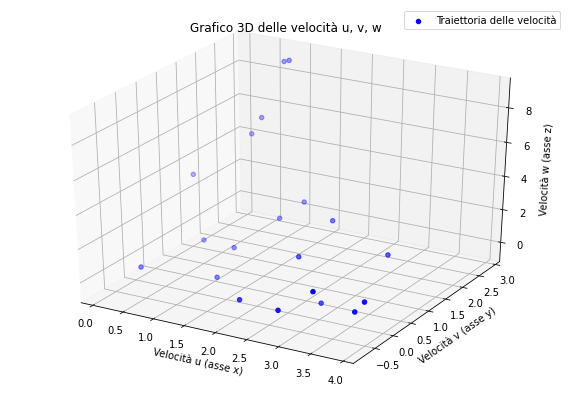

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generazione di 20 istanti temporali
n_tempi = 20
time = np.arange(n_tempi)

# Generazione di dati casuali per le componenti u, v, w
np.random.seed(42)  # Per avere risultati riproducibili
u = 2 + np.random.uniform(low=-2, high=2, size=n_tempi)  # Velocità orizzontale (x)
v = 1 + np.random.uniform(low=-2, high=2, size=n_tempi)  # Velocità verticale (y)
w = 0.4 + v**2 + np.random.uniform(low=-1, high=1, size=n_tempi)  # Velocità perpendicolare (z)

# Generazione di dati fittizi per la temperatura, intorno ai 20 gradi
temperature = np.random.normal(loc=20, scale=0.5, size=n_tempi)  # Media 20, deviazione standard 0.5

# Creazione del dataframe con i dati simulati
datiorari = pd.DataFrame({
    'u': u,
    'v': v,
    'w': w,
    'temperature': temperature
})

print("DataFrame generato:")
print(datiorari)

# Creazione di un grafico 3D delle velocità u, v, w
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot delle velocità con linee connesse dal tempo
ax.scatter(datiorari['u'], datiorari['v'], datiorari['w'], color='b', marker='o', label='Traiettoria delle velocità')

# Aggiunta di etichette agli assi
ax.set_xlabel('Velocità u (asse x)')
ax.set_ylabel('Velocità v (asse y)')
ax.set_zlabel('Velocità w (asse z)')
ax.set_title('Grafico 3D delle velocità u, v, w')

# Mostra la legenda
ax.legend()

# Mostra il grafico
plt.show()


## test the algorithm

In [3]:
Rotation_1_2_3(datiorari)

,urot,vrot,wrot
0,2.595125,0.709185,-0.355323
1,2.586253,-1.956850,-2.117129
2,1.402397,-1.042141,-2.408630
3,2.635965,-0.553310,-0.869761
4,1.043117,0.497456,-0.299595
5,4.969544,1.699085,2.357951
6,0.133051,-0.278648,-0.056962
7,3.521477,-0.450517,-1.715392
8,3.591387,0.268011,-0.549073
9,1.794511,-1.900103,-1.428739


In [5]:
uorig = datiorari.iloc[:,0].values
vorig = datiorari.iloc[:,1].values
worig = datiorari.iloc[:,2].values

In [6]:
urot = Rotation_1_2_3(datiorari, zero_rot=True, first_rot=True, second_rot=False).iloc[:,0].values
vrot = Rotation_1_2_3(datiorari, zero_rot=True, first_rot=True, second_rot=False).iloc[:,1].values
wrot = Rotation_1_2_3(datiorari, zero_rot=True, first_rot=True, second_rot=False).iloc[:,2].values

In [7]:
print(np.mean(vorig),np.mean(vrot))

0.8193158570834536 -4.163336342344337e-17


In [8]:
print(np.mean(worig),np.mean(wrot))

2.3399560705882956 0.0


In [9]:
print(np.mean(worig*vorig)-np.mean(worig)*np.mean(vorig),np.mean(wrot*vrot)-np.mean(wrot)*np.mean(vrot))

2.647080110223917 2.4049136761188388


NB: second rot works but we wont be usin it

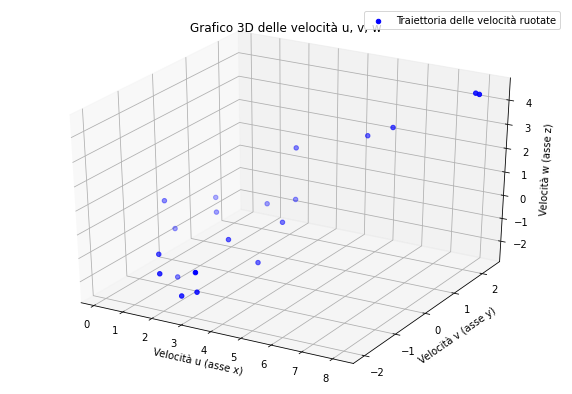

In [10]:
# Creazione di un grafico 3D delle velocità u, v, w
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot delle velocità con linee connesse dal tempo
ax.scatter(urot,vrot, wrot, color='b', marker='o', label='Traiettoria delle velocità ruotate')

# Aggiunta di etichette agli assi
ax.set_xlabel('Velocità u (asse x)')
ax.set_ylabel('Velocità v (asse y)')
ax.set_zlabel('Velocità w (asse z)')
ax.set_title('Grafico 3D delle velocità u, v, w')

# Mostra la legenda
ax.legend()

# Mostra il grafico
plt.show()


(e.g. look at y (v) axis)